In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from datetime import datetime, timedelta

# NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Misc
import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ameyg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ameyg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Task 1: Sentiment Labeling

In [4]:
#Step 1: Load the dataset
df = pd.read_csv("test.csv")

print(df.describe())

             Subject   body      date                     from
count           2191   2191      2191                     2191
unique          1251   1539       690                       10
top     (No Subject)  \n\n   7/1/2011  lydia.delgado@enron.com
freq             141     21         9                      284


In [5]:
# Step 2: Rename 'from' column to avoid keyword conflict
df.rename(columns={'from': 'sender'}, inplace=True)

# Step 3: Combine 'Subject' and 'body' into a single 'message' column
df['message'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')

# Step 4: Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Step 5: Drop rows with invalid/missing dates
df.dropna(subset=['date'], inplace=True)

# Step 6: Apply VADER sentiment labeling
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['message'].apply(get_sentiment)

# Step 7: Save labeled data (optional)
df.to_csv("labeled_test.csv", index=False)

# Step 8: Preview result
df[['sender', 'date', 'message', 'Sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ameyg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sender,date,message,Sentiment
0,sally.beck@enron.com,2010-05-10,EnronOptions Update! EnronOptions Announcement...,Positive
1,eric.bass@enron.com,2010-07-29,"(No Subject) Marc,\n\nUnfortunately, today is ...",Positive
2,sally.beck@enron.com,2011-07-25,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,johnny.palmer@enron.com,2010-03-25,RE: My new work email we were thinking papasit...,Neutral
4,lydia.delgado@enron.com,2011-05-21,Bet Since you never gave me the $20 for the la...,Positive


# Task 2: Exploratory Data Analysis (EDA)

In [7]:
# 1. Data structure overview
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Subject    2191 non-null   object        
 1   body       2191 non-null   object        
 2   date       2191 non-null   datetime64[ns]
 3   sender     2191 non-null   object        
 4   message    2191 non-null   object        
 5   Sentiment  2191 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 102.8+ KB
None
             Subject   body                           date  \
count           2191   2191                           2191   
unique          1251   1539                            NaN   
top     (No Subject)  \n\n                             NaN   
freq             141     21                            NaN   
mean             NaN    NaN  2010-12-31 02:17:21.716111360   
min              NaN    NaN            2010-01-01 00:00:00   
25%              N

Missing values:
 Subject      0
body         0
date         0
sender       0
message      0
Sentiment    0
dtype: int64


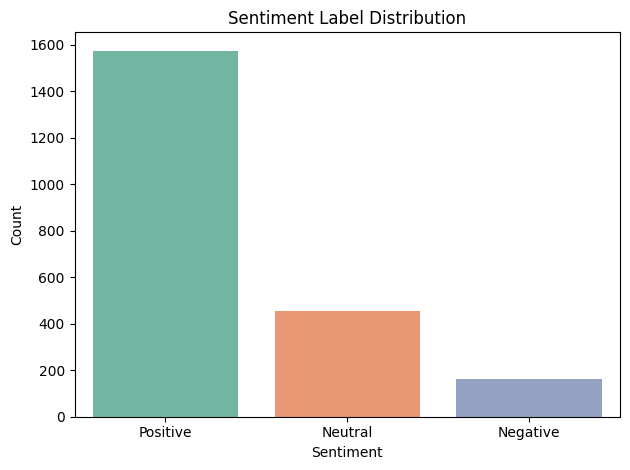

In [8]:
# 2. Missing values check
missing = df.isnull().sum()
print("Missing values:\n", missing)

# 3. Sentiment label distribution
sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

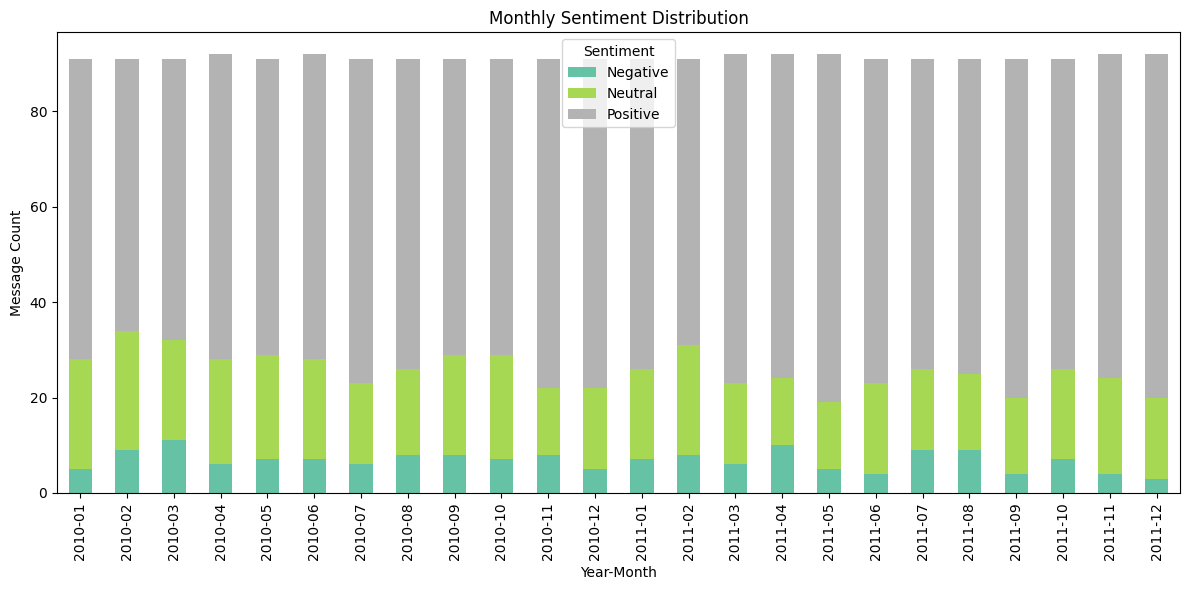

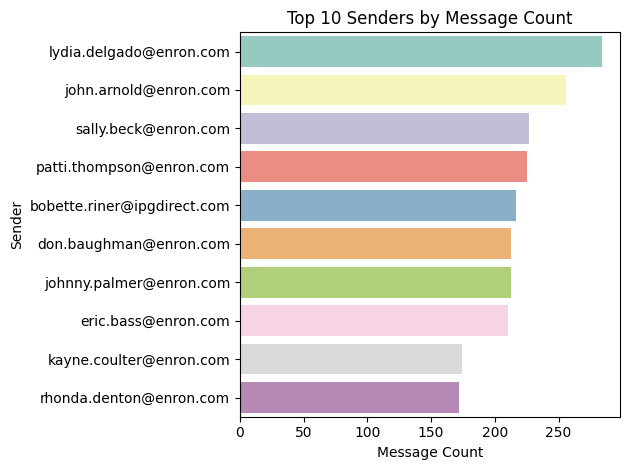

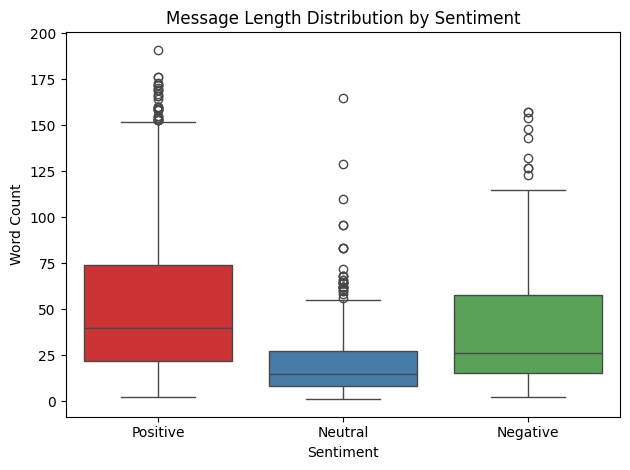

In [9]:
# 4. Messages over time
df['year_month'] = df['date'].dt.to_period('M')
monthly_sentiment = df.groupby(['year_month', 'Sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Monthly Sentiment Distribution")
plt.xlabel("Year-Month")
plt.ylabel("Message Count")
plt.tight_layout()
plt.show()

# 5. Messages per sender
top_senders = df['sender'].value_counts().head(10)
sns.barplot(x=top_senders.values, y=top_senders.index, palette='Set3')
plt.title("Top 10 Senders by Message Count")
plt.xlabel("Message Count")
plt.ylabel("Sender")
plt.tight_layout()
plt.show()

# 6. Average message length by sentiment
df['msg_len'] = df['message'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Sentiment', y='msg_len', data=df, palette='Set1')
plt.title("Message Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

# Task 3: Employee Score Calculation

In [11]:
# Step 1: Assign sentiment score
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['score'] = df['Sentiment'].map(score_map)

# Step 2: Extract month-year for grouping
df['month'] = df['date'].dt.to_period('M')

# Step 3: Aggregate score per employee per month
monthly_scores = df.groupby(['sender', 'month'])['score'].sum().reset_index()
monthly_scores.rename(columns={'score': 'monthly_score'}, inplace=True)

# Step 4: Preview results
monthly_scores.head()

,sender,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,3
4,bobette.riner@ipgdirect.com,2010-05,3


# Task 4: Employee Ranking

In [13]:
#Sort by month, score (descending for positive), sender (alphabetical)
monthly_scores_sorted = monthly_scores.sort_values(by=['month', 'monthly_score', 'sender'], ascending=[True, False, True])

#Get top 3 positive employees per month
top_positive = monthly_scores_sorted.groupby('month').head(3)

#Sort by month, score (ascending for negative), sender (alphabetical)
monthly_scores_sorted_neg = monthly_scores.sort_values(by=['month', 'monthly_score', 'sender'], ascending=[True, True, True])

#Get top 3 negative employees per month
top_negative = monthly_scores_sorted_neg.groupby('month').head(3)

#Preview results
print("Top 3 Positive Employees Per Month:")
print(top_positive)

print("\nTop 3 Negative Employees Per Month:")
print(top_negative)

Top 3 Positive Employees Per Month:
                          sender    month  monthly_score
120      kayne.coulter@enron.com  2010-01             14
48           eric.bass@enron.com  2010-01              9
144      lydia.delgado@enron.com  2010-01              9
73         john.arnold@enron.com  2010-02             12
97       johnny.palmer@enron.com  2010-02             10
..                           ...      ...            ...
94         john.arnold@enron.com  2011-11             10
22   bobette.riner@ipgdirect.com  2011-11              9
71           eric.bass@enron.com  2011-12             12
191     patti.thompson@enron.com  2011-12             12
167      lydia.delgado@enron.com  2011-12             10

[72 rows x 3 columns]

Top 3 Negative Employees Per Month:
                          sender    month  monthly_score
0    bobette.riner@ipgdirect.com  2010-01              1
192      rhonda.denton@enron.com  2010-01              1
216         sally.beck@enron.com  2010-01        

# Task 5: Flight Risk Identification

In [15]:
# Filter negative messages only
negative_df = df[df['Sentiment'] == 'Negative'].copy()

#Sort by sender and date
negative_df = negative_df.sort_values(by=['sender', 'date'])

#Rolling window check for 4+ negative messages in 30 days
flight_risks = set()

for sender in negative_df['sender'].unique():
    sender_df = negative_df[negative_df['sender'] == sender]
    dates = sender_df['date'].tolist()
    
    for i in range(len(dates)):
        count = 1
        for j in range(i+1, len(dates)):
            if (dates[j] - dates[i]).days <= 30:
                count += 1
                if count >= 4:
                    flight_risks.add(sender)
                    break
            else:
                break

#Output flight risk employee list
flight_risk_list = list(flight_risks)
print("Flight Risk Employees:")
print(flight_risk_list)

Flight Risk Employees:
['patti.thompson@enron.com', 'johnny.palmer@enron.com', 'sally.beck@enron.com', 'eric.bass@enron.com', 'bobette.riner@ipgdirect.com']


# Task 6: Predictive Modeling

In [17]:
#Feature engineering
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['message'].apply(lambda x: len(str(x)))
df['month'] = df['date'].dt.to_period('M')
df['month_str'] = df['month'].astype(str)

#Message frequency and average metrics per employee per month
features_df = df.groupby(['sender', 'month_str']).agg(
    msg_count=('message', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_char_count=('char_count', 'mean'),
    sentiment_score=('score', 'sum')
).reset_index()

#Prepare features and target
X = features_df[['msg_count', 'avg_word_count', 'avg_char_count']]
y = features_df['sentiment_score']

#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

#Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 3.3660053374417873
R2 Score: 0.7134891274765081


# VISUALISATIONS

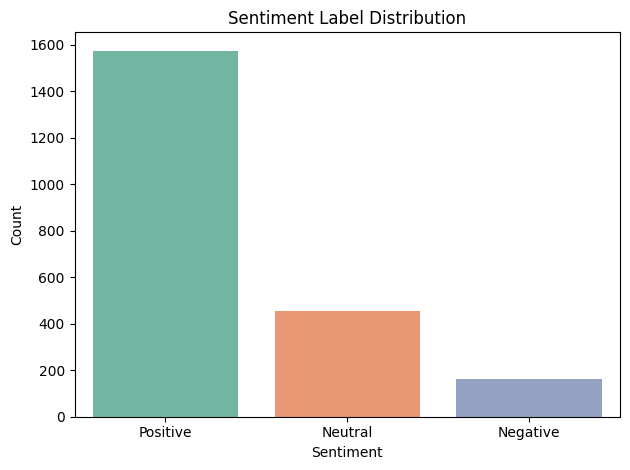

In [30]:
# Chart 1: Sentiment Label Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Sentiment', palette='Set2')
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

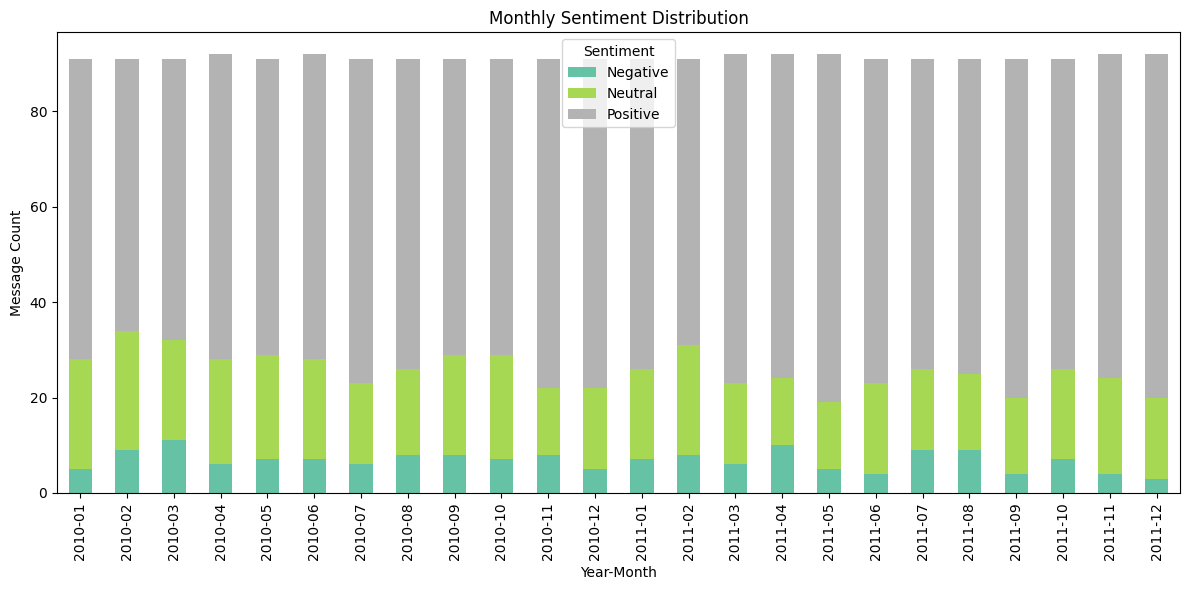

In [32]:
# Chart 2: Monthly Sentiment Trends
df['year_month'] = df['date'].dt.to_period('M')
monthly_sentiment = df.groupby(['year_month', 'Sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Monthly Sentiment Distribution")
plt.xlabel("Year-Month")
plt.ylabel("Message Count")
plt.tight_layout()
plt.show()

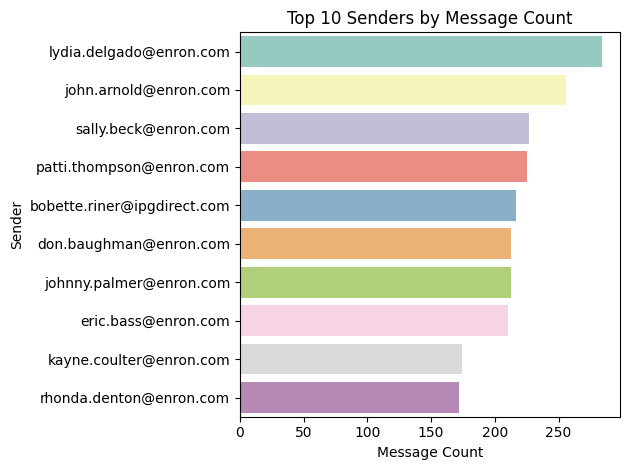

In [34]:
# Chart 3: Top 10 Senders by Message Count
top_senders = df['sender'].value_counts().head(10)
sns.barplot(x=top_senders.values, y=top_senders.index, palette='Set3')
plt.title("Top 10 Senders by Message Count")
plt.xlabel("Message Count")
plt.ylabel("Sender")
plt.tight_layout()
plt.show()

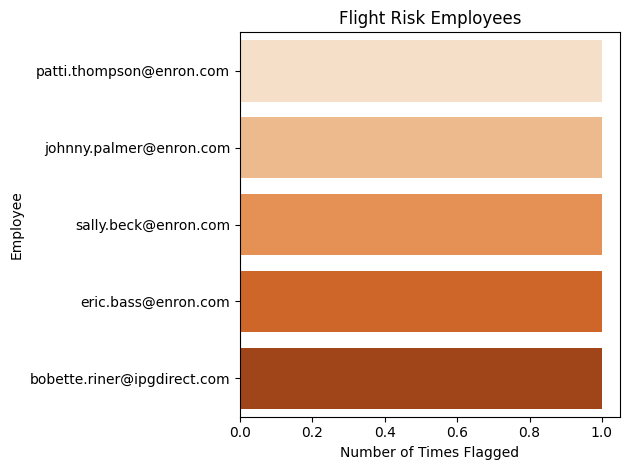

In [36]:
# Chart 4: Flight Risk Employees (Count per Employee)
import collections
flight_risk_counts = collections.Counter(flight_risk_list)
sns.barplot(x=list(flight_risk_counts.values()), y=list(flight_risk_counts.keys()), palette='Oranges')
plt.title("Flight Risk Employees")
plt.xlabel("Number of Times Flagged")
plt.ylabel("Employee")
plt.tight_layout()
plt.show()

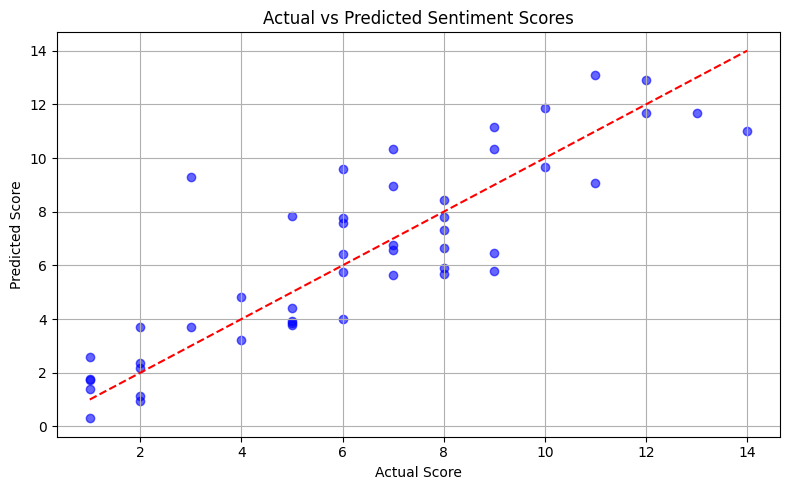

In [38]:
# Chart 5: Predicted vs Actual Sentiment Score
import numpy as np

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted Sentiment Scores")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.grid(True)
plt.tight_layout()
plt.show()